# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [1]:
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.keras import layers, models

We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [2]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [3]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

Let us define a simple dataset, and inspect a few samples.

In [4]:
X_train, Y_train = generate_dataset(10000)
decoder_input_train = shift_right(Y_train)

X_val, Y_val = generate_dataset(1000)
decoder_input_val = shift_right(Y_val)

In [5]:
i =  np.random.randint(10000)
print(i)
print("Infix: ", X_train[i])
print("Postfix: ", Y_train[i])
print("Teacher forcing: ",decoder_input_train[i])
print("Infix : ",decode_sequence(X_train[i],id_to_token))
print("Posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("Teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

1903
Infix:  [ 3  3  9  8 10  4  5  3  3 10  5 13  4  5  3 12  5 13  4  4  4  2  0  0
  0  0  0  0  0  0]
Postfix:  [ 9 10  8 10 13  5 12 13  5  5  5  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
Teacher forcing:  [ 1  9 10  8 10 13  5 12 13  5  5  5  2  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
Infix :  ( ( a / b ) + ( ( b + e ) + ( d + e ) ) )
Posfix notation:  a b / b e + d e + + +
Teacher forcing :  SOS a b / b e + d e + + +


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [6]:
def prefix_accuracy_single(y_true, y_pred, id_to_token=id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.

# **Design, Implementation and Testing of the solution**

To solve the given task I decided to implement an Encoder-Decoder architecture using Transformers, given the fact that they are very effective for sequence to sequence translation tasks. In fact, I reached a **mean score of 1 with 0 standard deviation**.


The structure of the notebook is the following:


1.   **Imports** - here I import everything that is needed in the notebook.
2.   **Model Architecture** - here I define and implement the architecture (encoder, decoder, transformer and the hyperparameters).
3.   **Autoregressive Decode** - here I implement the autoregressive decode procedure.
4.   **Load model parameters** - here are the commands to load pretrained model's weights.
5.   **Training** - here I define how the dataset is generated, the model is trained and the loss function + prefix accuracy are plotted. Moreover, in this section there is also the code for saving model parameters.
5.   **Testing** - The final result obtained with the provided test function is here.
6.  **Consideration on Hyperparamters** - brief explanation of why I chose the particular hyperparameters.

### Imports

In [7]:
import keras
from keras import Model
from keras.layers import Input, Embedding, Dense
from keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
from tabulate import tabulate

## Model Architecture

### Embedding layer

I implement the PositionalEmbedding class that combines an Embedding layer with a positional encoding and in particular I use the sinusodial encoding, defined in the following code snippet.

In [8]:
# this encoding I took from https://arminnorouzi.github.io/posts/2023/05/blog-post-13/

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]
  depths = np.arange(depth)[np.newaxis, :]/depth

  angle_rates = 1 / (10000**depths)
  angle_rads = positions * angle_rates

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [9]:
class PositionalEmbedding(tf.keras.layers.Layer):

  def __init__(self, vocab_size, embedding_dim):

    super().__init__()
    self.embedding_dim = embedding_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.pos_encoding = positional_encoding(length=MAX_LEN, depth=embedding_dim)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

### Encoder

In this subsection I implement the EncoderLayer with the usual architecture:
 - Self Attention
 - Dropout
 - Add and Normalize
 - Feedforward network
 - Final Add and Normalize

After that I define the Encoder class that adds to an input sequence the previously defined embedding and feeds it to `num_layers` EncoderLayers.

In [10]:
class EncoderLayer(tf.keras.layers.Layer):

  def __init__(self,*, embedding_dim, num_heads, intermediate_dim, dropout_rate=0.1):

    super().__init__()

    self.supports_masking = True

    self.self_attention = tf.keras.layers.MultiHeadAttention(num_heads,
                                                             key_dim = embedding_dim // num_heads,
                                                             dropout=dropout_rate)

    self.ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(intermediate_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])

    self.layernorm1 = tf.keras.layers.LayerNormalization()
    self.layernorm2 = tf.keras.layers.LayerNormalization()

    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)


  def call(self, x, mask=None, training=False):

    attn_out = self.self_attention(query=x, key=x, value=x, attention_mask=mask)
    attn_out = self.dropout1(attn_out, training=training)
    out1 = self.layernorm1(x+attn_out)
    ffn_out = self.ffn(out1)
    out2 = self.layernorm2(ffn_out + out1)

    return out2

In [11]:
class Encoder(tf.keras.layers.Layer):

  def __init__(self, *, num_layers, embedding_dim, num_heads,
               intermediate_dim, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.embedding_dim = embedding_dim
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, embedding_dim=embedding_dim)

    self.enc_layers = [
        EncoderLayer(embedding_dim=embedding_dim,
                     num_heads=num_heads,
                     intermediate_dim=intermediate_dim,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, training=False):

    # Get the positional embedding of the input
    x = self.pos_embedding(x)
    padding_mask = x._keras_mask

    # Prepare the correct shape of the mask to be given to the EncoderLayers
    if padding_mask is not None:
       padding_mask = tf.cast(padding_mask[:, :, tf.newaxis], dtype=tf.float32)

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, mask=padding_mask, training=training)

    return x, padding_mask

This is just a toy test to control whether the Encoder class works and there are no internal problems, expecially with the shapes of inflowing tensors.

In [12]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         embedding_dim=128,
                         num_heads=8,
                         intermediate_dim=46,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(X_train[:5], training=False)[0]

print(X_train[:5].shape)
print(sample_encoder_output.shape)

(5, 30)
(5, 30, 128)


### Decoder

In this subsection I implement the DecoderLayer with the usual architecture:
 - Causal Self Attention
 - Dropout layer
 - Add and Normalize
 - Cross Attention
 - Dropout layer
 - Add and Normalize
 - Feedforward network
 - Dropout layer
 - Final Add and Normalize

After that I define the Decoder class that adds to an input sequence the previously defined embedding, a dropout layer and feeds it to `num_layers` DecoderLayers.

The Decoder when called expects the padding mask, that will be provided by the Encoder inside the combined Transformer class.

In [15]:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self,
               *,
               embedding_dim,
               num_heads,
               intermediate_dim,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.supports_masking = True

    self.causal_self_attention = tf.keras.layers.MultiHeadAttention(num_heads,
                                                                    key_dim=embedding_dim // num_heads,
                                                                    dropout=dropout_rate)

    self.cross_attention = tf.keras.layers.MultiHeadAttention(num_heads,
                                                              key_dim=embedding_dim // num_heads,
                                                              dropout=dropout_rate)

    self.ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(intermediate_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])

    self.layernorm1 = tf.keras.layers.LayerNormalization()
    self.layernorm2 = tf.keras.layers.LayerNormalization()
    self.layernorm3 = tf.keras.layers.LayerNormalization()

    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    self.dropout3 = tf.keras.layers.Dropout(dropout_rate)


  def call(self, x, context, padding_mask, training=False):

    # Self attention of the decoder input
    attn1_out = self.causal_self_attention(query=x, key=x, value=x, use_causal_mask=True, training=training)
    attn1_out = self.dropout1(attn1_out, training=training)

    out1 = self.layernorm1(x + attn1_out)

    # Cross attention of the encoder output
    attn2_out = self.cross_attention(key=context, value=context, query=out1, attention_mask=padding_mask, training=training)
    attn2_out = self.dropout2(attn2_out, training=training)

    out2 = self.layernorm2(attn2_out+out1)

    out = self.ffn(out2)
    out = self.dropout3(out, training=training)
    out = self.layernorm3(out + out2)

    return out

In [16]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self, *, num_layers, embedding_dim, num_heads, intermediate_dim, vocab_size,
               dropout_rate=0.1):

    super(Decoder, self).__init__()

    self.embedding_dim = embedding_dim
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             embedding_dim=embedding_dim)

    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    self.dec_layers = [
        DecoderLayer(embedding_dim=embedding_dim, num_heads=num_heads,
                     intermediate_dim=intermediate_dim, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

  def call(self, x, context, padding_mask, training=False):

    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context, padding_mask, training=training)

    return x

### Transformer

The class defined in this subsection is the final model that combines the Encoder and Decoder classes.
- Takes as input a tuple (encoder_input, decoder_input), feeding the entire input sequence to the Encoder and computing the representation of the sequence and the padding mask.

- The decoder_input is added to the two results and all of them are given to the Decoder.

- The output of the Decoder is finally processed by a Dense layer that outputs the token scores.

In [17]:
class Transformer(tf.keras.Model):

  def __init__(self, *, sequence_length, num_layers, embedding_dim, num_heads, intermediate_dim,
               vocab_size, dropout_rate=0.1):
    super().__init__()

    self.encoder = Encoder(num_layers=num_layers, embedding_dim=embedding_dim,
                           num_heads=num_heads, intermediate_dim=intermediate_dim,
                           vocab_size=vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, embedding_dim=embedding_dim,
                           num_heads=num_heads, intermediate_dim=intermediate_dim,
                           vocab_size=vocab_size,
                           dropout_rate=dropout_rate)

    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs):

    context, x  = inputs
    context, padding_mask = self.encoder(context)
    x = self.decoder(x, context, padding_mask)
    logits = self.dense(x)

    try:
      # Drop the keras mask
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

### Hyperparameters and Model Summary


In the following cells, the hyperparameters are defined and the model is instantiated.

As can be seen in the last cell, with the used hyperparameters the model has just 44,207 parameters. For more information on why this number of parameters was used refer to the last section of the notebook.

In [42]:
embedding_dim = 32
num_heads = 2
intermediate_dim = 64
num_layers = 2
dropout_rate = 0.1
epochs = 10
batch_size = 32

transformer = Transformer(
    sequence_length=MAX_LEN,
    vocab_size=VOCAB_SIZE,
    num_layers=num_layers,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    intermediate_dim=intermediate_dim,
    dropout_rate=dropout_rate
)

In [43]:
# Building the model to get the number of parameters in the summary
dummy_input = tf.random.uniform((1, MAX_LEN), dtype=tf.int32, maxval=VOCAB_SIZE)
_ = transformer((dummy_input, dummy_input))

In [44]:
transformer.summary()

Model: "transformer_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_3 (Encoder)             │ ?                      │        17,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │        26,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (1, 30, 15)            │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,207 (172.68 KB)

 Trainable params: 44,207 (172.68 KB)

 Non-trainable params: 0 (0.00 B)

## Autoregressive decode procedure


The autoregressive decode procedure is implemented in such a way that the sequence of length MAX_LEN is created and filled with PAD_id's, apart from the first that is a SOS_id. The whole sequence is fed to the decoder and then the sequence is updated with the next predicted token. When the model predicts EOS_ID the generation stops.

While this may be less flexible than step by step adding new dimensions to the predicted sequence for our case it works just fine, because we know that the sequence will never be larger than the input sequence (there are no braces in postfix notation), that is limited by MAX_LEN.

In [21]:
def autoregressive_decode(model, input_sequence):

  # Generate the input for the decoder - fixed size of MAX_LEN. First token SOS_ID and everything else PAD_ID
  decoder_input = tf.fill([1, MAX_LEN], PAD_ID)
  decoder_input = tf.tensor_scatter_nd_update(decoder_input, [[0, 0]], [SOS_ID])

  # Predict the next tokens, until EOS_ID is generated
  for i in range(1, MAX_LEN):
    logits = model((input_sequence, decoder_input), training=False)
    next_token = tf.argmax(logits[:, i - 1, :], axis=-1, output_type=tf.int32)
    decoder_input = tf.tensor_scatter_nd_update(decoder_input, [[0, i]], [next_token[0]])

    if next_token == EOS_ID:
      break

  return decoder_input.numpy().squeeze()

## Load pre-trained model's parameters

The model parameters can be downloaded using the following gdown command and they can be loaded to the built model with the next code snippet.

In [ ]:
!gdown 13SRSzyiO37ugn4ySPNrqY4ESK4RmKpfD

Downloading...
From: https://drive.google.com/uc?id=13SRSzyiO37ugn4ySPNrqY4ESK4RmKpfD
To: /content/eff_transf.weights.h5
100% 813k/813k [00:00<00:00, 109MB/s]


In [ ]:
transformer.load_weights("eff_transf.weights.h5")

## Training

### Prepare dataset

Here, I define the function that I will use to generate the datasets (validation and train), using the previously defined batch size.

In [22]:
def create_tf_dataset(X, Y, batch_size=32):

    decoder_input = shift_right(Y)
    dataset = tf.data.Dataset.from_tensor_slices(((X, decoder_input), Y))
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

The two required datasets are created in the following cell and the shapes of an example batch are printed to be sure that everything works.

In [23]:
train_dataset = create_tf_dataset(X_train, Y_train, batch_size=batch_size)
val_dataset = create_tf_dataset(X_val, Y_val, batch_size=batch_size)

for batch in train_dataset.take(1):
    (encoder_input, decoder_input), decoder_target = batch
    print("Encoder input shape:", encoder_input.shape)
    print("Decoder input shape:", decoder_input.shape)
    print("Target shape:", decoder_target.shape)

Encoder input shape: (32, 30)
Decoder input shape: (32, 30)
Target shape: (32, 30)


### Compile and train

I define the callback to use during training. The callback after each epoch prints some of the predicitons that the model is able to make. Moreover the callback computes for every second epoch the mean and standard deviation of the prefix accuracy across five rounds rounds of 10 examples each.

This slows down the training process but because overall the proces doesn't need to much time I decided to use it.

In [24]:
class FormulaPreviewCallback(tf.keras.callbacks.Callback):

    def __init__(self, generation_method, num_examples=3):

        super().__init__()
        self.num_examples = num_examples
        self.generation_method = generation_method
        self.mean_acc = []
        self.std_acc = []

    def on_epoch_end(self, epoch, logs=None):
        infix_s, postfix_s = generate_dataset(self.num_examples)

        if epoch % 2 == 0:
            accuracies = []

            for _ in range(5):
                infix_batch, postfix_batch = generate_dataset(10)

                for infix, true_postfix in zip(infix_batch, postfix_batch):
                    y_pred = self.generation_method(self.model, infix[tf.newaxis, :])

                    acc = prefix_accuracy_single(y_pred[1:], true_postfix)
                    accuracies.append(acc)

            mean = np.mean(accuracies)
            std = np.std(accuracies)

            self.mean_acc.append(mean)
            self.std_acc.append(std)

        data = []
        print(f"\n--- Model predictions after epoch {epoch+1} ---")
        for i, infix in enumerate(infix_s):

            y_pred = self.generation_method(self.model, infix[tf.newaxis, :])

            data.append([
                f"Example {i+1}",
                str(decode_sequence(infix, id_to_token)),
                str(decode_sequence(y_pred[1:], id_to_token)),
                str(decode_sequence(postfix_s[i], id_to_token))
            ])

        headers = ["Example", "Infix notation", "Predicted postfix notation", "True postfix notation"]
        print(tabulate(data, headers=headers, tablefmt="grid"))

In [45]:
preview_cb = FormulaPreviewCallback(
    generation_method = autoregressive_decode,
    num_examples = 3
)

Here, the model is compiled and the fit method is invoked starting the training of the model. I used the usual Adam optimizer with fixed learning rate and the sparse categorical crossentropy.

We can already see that the model performs well, because the predictions, even though not representative, are, apart from one, aligned with the true labels.

In [46]:
transformer.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        preview_cb
    ]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8290 - loss: 0.5544
--- Model predictions after epoch 1 ---
+-----------+-------------------------------------------+------------------------------+-------------------------+
| Example   | Infix notation                            | Predicted postfix notation   | True postfix notation   |
+===========+===========================================+==============================+=========================+
| Example 1 | ( c - ( c / c ) )                         | c c c / -                    | c c c / -               |
+-----------+-------------------------------------------+------------------------------+-------------------------+
| Example 2 | ( ( d + a ) * ( e * d ) )                 | d a + e d * *                | d a + e d * *           |
+-----------+-------------------------------------------+------------------------------+-------------------------+
| Example 3 | ( ( ( a * c ) - ( a - a ) ) / ( d - b ) ) | a c * a - 

In the section below I plot the training loss as well as the mean and standard deviation of the prefix accuracy computed in the callback for every second epoch.

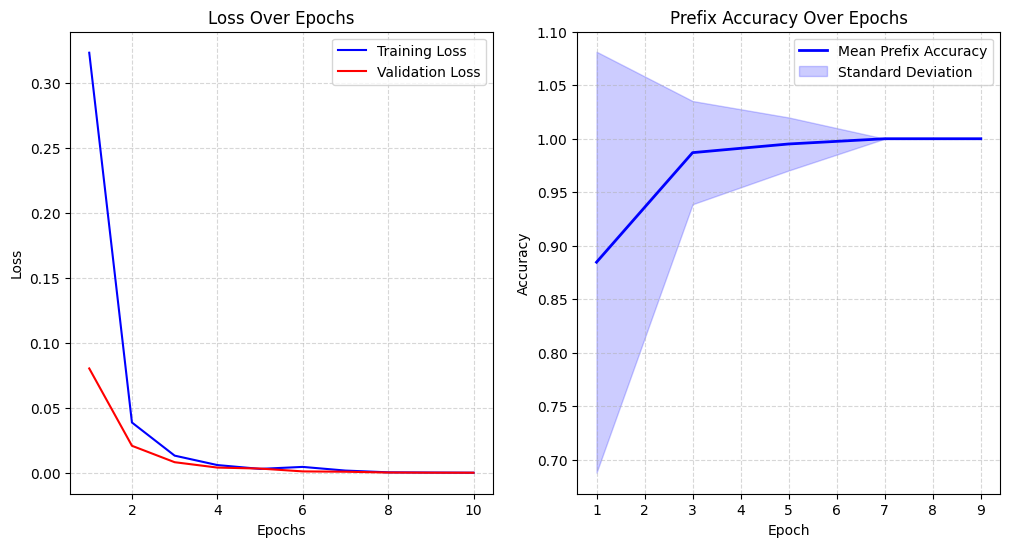

In [48]:
# Plot the loss
loss = history.history['loss']
val_loss = history.history.get('val_loss')
epochs = range(1, len(loss)+1)

fig = plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Plot the accuracy
plt.subplot(1,2,2)
mean_acc = np.array(preview_cb.mean_acc)
std_acc = np.array(preview_cb.std_acc)
epochs = np.arange(1, 2 * len(mean_acc) + 1, 2)

plt.plot(epochs, mean_acc, label='Mean Prefix Accuracy', color='blue', linewidth=2)

plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='blue', alpha=0.2, label='Standard Deviation')
plt.title('Prefix Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top=1.1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()


plt.show()


The main thing to notice is how the standard deviation of the predictions of the model decreases, indicating that the model is more and more stable in the accuracy of its predictions.

### Saving model paramaters

The code to save the model parameters after training is here provided.

In [50]:
# transformer.save_weights("eff_transf.weights.h5")

In [51]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# !cp eff_transf.weights.h5 /content/drive/MyDrive/DL_notebooks/Exam_June/eff_transf.weights.h5

## Testing


In this section the provided test function is invoked and the model's performance on 10 rounds of 20 examples each is recorded. The obtained final score is:
-  mean prefix accuracy = 1;
-  standard deviation = 0.

In [49]:
def test(no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("round=",i)
    X_test, Y_test = generate_dataset(no)
    scores = []
    for j in range(no):
      encoder_input=X_test[j][tf.newaxis, :]
      generated = autoregressive_decode(transformer, encoder_input)[1:]
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

res, std = test(20,10)
print("score=",res,"std=",std)

round= 0
round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
score= 1.0 std= 0.0


## Considerations on the Hyperparameters - formulae's length distribution

I tested the performance of the model using different hyperparameters. I was trying to use the least ammount of parameters for the task mantaining a perfect score. I found that with 5,247 parameters I was still able to obtain the score of 1.0, the same as with 44,207.

To chose between the two configurations I tried to see how robust the two models were with respect to the change of the distribution of the length of the formulae (change  `generate_infix_expression: random.random() < p`).

I noticed that the smaller model is more sensitive to the change of the length. In fact for $p < 0.5$ the performance decreases (approximately by 0.05) and for $p > 0.5$ the performance gradually increases.

With the bigger model I observed a different behavior, in fact, the performance remains 1.0 for $p ∈ [0.2,0.3,0.4,0.6,0.7]$, and because of this I chose to use the this model.